In [1]:
import warnings
import numpy as np 
import pandas as pd 

import os
import torch
import torch.nn as nn 
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
warnings.filterwarnings('ignore')
k=0

In [3]:
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from   torchtext.vocab import FastText
import nltk
from nltk import ngrams
from nltk.stem import WordNetLemmatizer as wnl


In [4]:
import torchtext.vocab as vocab
import fasttext
from torch.utils.data import Dataset ,DataLoader


In [5]:
data=pd.read_csv("/kaggle/input/question-pairs-dataset/questions.csv")

In [6]:
from keras.utils import pad_sequences

In [7]:
data['question2']=data['question2'].apply(lambda x :simple_preprocess(str(x)) )
data['question1']=data['question1'].apply(lambda x :simple_preprocess(str(x)) )

In [8]:
all_q=data['question1'].append(data['question2'],ignore_index=True)

In [9]:
a=all_q.dropna().tolist()

In [10]:
words=vocab.build_vocab_from_iterator(a)

In [11]:
data.dropna(inplace=True)

In [12]:
vocab1=words.get_stoi()


In [13]:
vocab1['<\s>']=0

In [14]:
def word_to_idx(x):
    return  [vocab1[i] for i in x]

In [15]:
data['question2']=data['question2'].apply(lambda x :word_to_idx(x) ) 
data['question1']=data['question1'].apply(lambda x :word_to_idx(x) )

In [16]:
data['question2']=data['question2'].apply(lambda x :pad_sequences([x],maxlen=212, value=0)[0] )
data['question1']=data['question1'].apply(lambda x :pad_sequences([x],maxlen=212,value=0)[0] )

In [17]:
class dataset(Dataset):
    def __init__(self,x,y,z):
         self.x=x
         self.z=z
         self.y=y
    def __len__(self):
        return len(self.x) 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx],self.z[idx]

In [18]:
x=torch.tensor(data['question2'])
y=torch.tensor(data['question1'])
z=torch.tensor(data['is_duplicate'])

In [19]:
train=dataset(x[:52224],y[:52224],z[:52224])
test=dataset(x[52224:60224],y[52224:60224],z[52224:60224])
valid=dataset(x[62224:72712],y[62224:72712],z[62224:72712])
train_set=DataLoader(train,batch_size=32,shuffle =True)
test_set=DataLoader(test,batch_size=32,shuffle =True)
valid_set=DataLoader(valid,batch_size=32,shuffle =True)

In [20]:
class sts(nn.Module):
        def __init__(self):
            super(sts,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(600,1)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
       
            con=torch.abs(x1 - x2)
            #print(con.shape)
            con=self.linear(con)
            return con.cuda()


In [153]:
import torch

def calculate_accuracy(predicted_labels, true_labels):

    predicted_labels = torch.argmax(predicted_labels, dim=1)
    # Compare predicted labels with true labels
    correct = torch.eq(predicted_labels, true_labels).float()
    # Calculate accuracy
    accuracy = torch.mean(correct)
    
    return accuracy.item()*100


In [154]:
model=sts().cuda()
loss=nn.BCEWithLogitsLoss()
optim=torch.optim.Adam(model.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [23]:
l_train=[]
v_train=[]
for i in range(10):
    model.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r=model(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,c.unsqueeze(-1).float().cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')

    
    v_l=0
    model.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r=model(a.cuda(),b.cuda())
            
            l=loss(r,c.unsqueeze(-1).float().cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 1632  train loss 0.6512701511383057 , accuracy : 0

0 train loss: 0.5572265523723235 accuracy : 0.0  , valid : 0.514981223134006 accuracy : 0.0

 iter 1632  train loss 0.3950958847999573 , accuracy : 0

1 train loss: 0.4395571281293444 accuracy : 0.0  , valid : 0.4843537780206378 accuracy : 0.0

 iter 1632  train loss 0.39474278688430786 , accuracy : 0

2 train loss: 0.3111464883629963 accuracy : 0.0  , valid : 0.5062841987010183 accuracy : 0.0

 iter 1632  train loss 0.22276082634925842 , accuracy : 0

3 train loss: 0.16788856048073036 accuracy : 0.0  , valid : 0.6013981250182885 accuracy : 0.0

 iter 1632  train loss 0.03042202815413475 , accuracy : 0

4 train loss: 0.07585779739219659 accuracy : 0.0  , valid : 0.7272544575446263 accuracy : 0.0

 iter 1632  train loss 0.09912614524364471 , accuracy : 0

5 train loss: 0.043495762470782066 accuracy : 0.0  , valid : 0.8131879097441348 accuracy : 0.0

 iter 1632  train loss 0.034717023372650146 , accuracy : 0

6 train loss: 0.03893

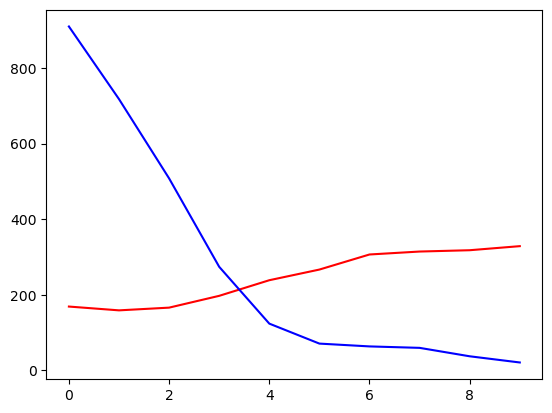

In [24]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [25]:
torch.save(model.state_dict(),'model.pth')
torch.save(model.state_dict(),'model.pth')

In [156]:
import torch

def calculate_accuracy2(predicted_labels, true_labels):

    # Compare predicted labels with true labels
    correct = torch.eq(predicted_labels>=.5, true_labels).float()
    # Calculate accuracy
    accuracy = torch.mean(correct)
    
    return accuracy.item()*100


In [157]:
s=nn.Sigmoid()

In [158]:
def test_classification2(device="cuda"):
        
        v_l=0
        model.eval()
        print()
        a_v=0
        with torch.no_grad():
            

            for (a,b,c) in test_set:
                r=model(a.cuda(),b.cuda())

                l=loss(r,c.unsqueeze(-1).float().cuda())
                v_l+=l.item()
                k=calculate_accuracy2(s(r),c.cuda())
                a_v+=k
        print(f" test : {v_l/ len(test_set)} accuracy : {a_v / len(test_set) }")
test_classification2()


 test : 1.0446877417564393 accuracy : 54.4328125


# model of cosing similarty

In [48]:
class sts_cosin(nn.Module):
        def __init__(self):
            super(sts_cosin,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(1,1)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()    
       
            #print(con.shape)
            return x2,x1

In [52]:
model2=sts_cosin().cuda()
loss=nn.CosineEmbeddingLoss()

optim=torch.optim.Adam(model2.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [29]:
l_train=[]
v_train=[]
for i in range(10):
    model2.train()
    t_l=0
    o=0
    a_t=0
    k=0
    for (a,b,c) in train_set:
        r,t=model2(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        c=(c-.1).sign()
        l=loss(r,t,c.cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')
    
    v_l=0
    model2.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r,t=model2(a.cuda(),b.cuda())
            c=(c-.1).sign()

            l=loss(r,t,c.cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 1632  train loss 0.27855056524276733 , accuracy : 0

0 train loss: 0.33562234738001634 accuracy : 0.0  , valid : 0.3156403090986537 accuracy : 0.0

 iter 1632  train loss 0.2791372537612915 , accuracy : 0

1 train loss: 0.29086542070624144 accuracy : 0.0  , valid : 0.3040802336593227 accuracy : 0.0

 iter 1632  train loss 0.24091026186943054 , accuracy : 0

2 train loss: 0.2581178232132658 accuracy : 0.0  , valid : 0.2971034299400521 accuracy : 0.0

 iter 1632  train loss 0.26634421944618225 , accuracy : 0

3 train loss: 0.23579644352909834 accuracy : 0.0  , valid : 0.289560766027468 accuracy : 0.0

 iter 1632  train loss 0.32389605045318604 , accuracy : 0

4 train loss: 0.21434828010615983 accuracy : 0.0  , valid : 0.2891287248490787 accuracy : 0.0

 iter 1632  train loss 0.18990176916122437 , accuracy : 0

5 train loss: 0.19276166039829454 accuracy : 0.0  , valid : 0.28199255757215547 accuracy : 0.0

 iter 1632  train loss 0.27601316571235657 , accuracy : 0

6 train loss: 0.174

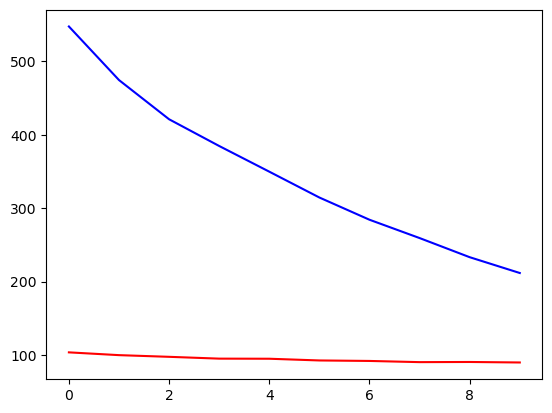

In [30]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [31]:
torch.save(model2,'model2.pt')
torch.save(model2,'model2.pt')

In [144]:
import torch

def calculate_accuracy3(predicted_labels, true_labels):
    predicted_labels[predicted_labels>0]=1
    predicted_labels[predicted_labels<0]=-1
    # Compare predicted labels with true labels
    correct = torch.eq(predicted_labels, true_labels).float()
    # Calculate accuracy
    accuracy = torch.mean(correct)
    
    return accuracy.item()*100


In [149]:
def test_classification2(device="cuda"):
            v_l=0
            model2.eval()
            print()
            a_v=0
            with torch.no_grad():

                for (a,b,c) in test_set:
                    r,t=model2(a.cuda(),b.cuda())
                    c=(c-.1).sign()

                    l=loss(r,t,c.cuda())
                    v_l+=l.item()
                    k=calculate_accuracy3(torch.cosine_similarity(r,t),c.cuda())
                    a_v+=k

            print(f" test : {v_l/ len(test_set)} accuracy : {a_v / len(test_set) }")
test_classification2()


 test : 1.52407106000185 accuracy : 37.5875


In [68]:
import torch.nn.functional as F


In [161]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [162]:
class sts_contrastive(nn.Module):
        def __init__(self):
            super(sts_contrastive,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,300,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(300*2,20)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :300], x2[:, 0,300:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :300], x1[:, 0,300:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
            x1= self.linear(x1).cuda()
            x2=self.linear(x2).cuda()
            #print(con.shape)
            return x2,x1

In [163]:
model3=sts_contrastive().cuda()
loss=ContrastiveLoss()

optim=torch.optim.Adam(model3.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [37]:
l_train=[]
v_train=[]
for i in range(10):
    model3.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r,t=model3(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,t,c.unsqueeze(-1).cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        o+=1
#        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} ",end='')
    
    v_l=0
    model3.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r,t=model3(a.cuda(),b.cuda())
            c=c.sign()

            l=loss(r,t,c.unsqueeze(-1).cuda())
            v_l+=l.item()
         #   k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 1632  train loss 0.8594357967376709 

0 train loss: 0.9772225773035019 accuracy : 0.0  , valid : 0.8753994714196135 accuracy : 0.0

 iter 1632  train loss 1.061659574508667 

1 train loss: 0.8101858833037755 accuracy : 0.0  , valid : 0.8302862210789832 accuracy : 0.0

 iter 1632  train loss 0.6407516002655029 

2 train loss: 0.6963996449850646 accuracy : 0.0  , valid : 0.8010014068426156 accuracy : 0.0

 iter 1632  train loss 0.5396146178245544 

3 train loss: 0.5587829092663585 accuracy : 0.0  , valid : 0.8124381016667296 accuracy : 0.0

 iter 1632  train loss 0.4468757212162018 

4 train loss: 0.43563092006918264 accuracy : 0.0  , valid : 0.860831302567953 accuracy : 0.0

 iter 1632  train loss 0.35564395785331726 

5 train loss: 0.33080338908578544 accuracy : 0.0  , valid : 0.8621217126889926 accuracy : 0.0

 iter 1632  train loss 0.1342855989933014 

6 train loss: 0.2592064615969053 accuracy : 0.0  , valid : 0.8974263510871224 accuracy : 0.0

 iter 1632  train loss 0.20490930

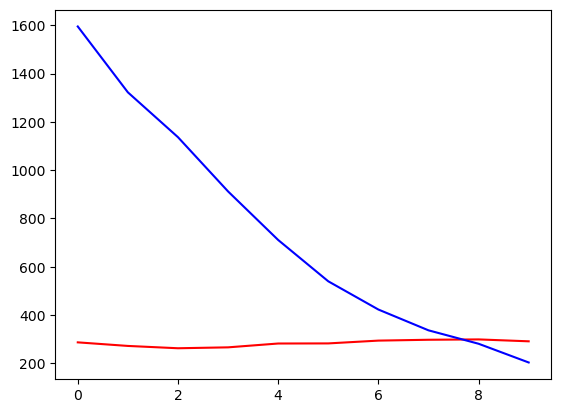

In [38]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


In [39]:
torch.save(model3,'model3.pt')
torch.save(model3,'model3.pth')

In [164]:
import torch

def calculate_accuracy3(predicted_labels, true_labels):

    # Compare predicted labels with true labels
    correct = torch.eq(predicted_labels.int(), true_labels).float()
    # Calculate accuracy
    accuracy = torch.mean(correct)
    
    return accuracy.item()*100


In [165]:
def test_classification2(device="cuda"):
    v_l=0
    model3.eval()
    print()
    a_v=0
    with torch.no_grad():
        for (a,b,c) in test_set:
            r,t=model3(a.cuda(),b.cuda())             
            l=loss(r,t,c.unsqueeze(-1).cuda())
            
            v_l+=l.item()
            k=calculate_accuracy3(F.pairwise_distance(r,t)>2,c.cuda())
            a_v+=k
        print(f" test : {v_l/ len(test_set)} accuracy : {a_v / len(test_set) }")
test_classification2()


 test : 1.3407693767547608 accuracy : 62.4125


In [96]:
class sts_cat(nn.Module):
        def __init__(self):
            super(sts_cat,self).__init__()
            self.embedded=nn.Embedding(len(vocab1),100)
            self.lstm=nn.LSTM(100,500,batch_first=True, bidirectional=True)
            self.linear=nn.Linear(1000,16)
            self.linear1=nn.Linear(16,2)
        def forward(self,x1,x2):
            x1=self.embedded(x1).cuda()
            x2=self.embedded(x2).cuda()

            x1,_=self.lstm(x1)
            x2,_=self.lstm(x2)
            x2=torch.cat((x2[:, -1, :500], x2[:, 0,500:]), dim=1).cuda()
            x1=torch.cat((x1[:, -1, :500], x1[:, 0,500:]), dim=1).cuda()
           # x2=x2[:, -1, :].cuda()
            #x1=x1[:, -1, :].cuda() 
            x1= self.linear(x1)
            x2= self.linear(x2)

            x1=x1*x2
            #print(con.shape)
            x1=self.linear1(x1)
            return x1

In [97]:
model4=sts_cat().cuda()
loss=nn.CrossEntropyLoss()
optim=torch.optim.Adam(model4.parameters())
schedular=torch.optim.lr_scheduler.ReduceLROnPlateau(optim,verbose=True,patience=5)

In [43]:
l_train=[]
v_train=[]
for i in range(10):
    model4.train()
    t_l=0
    o=0
    a_t=0
    for (a,b,c) in train_set:
        r=model4(a.cuda(),b.cuda())
        #print(r.shape,c.shape)
        l=loss(r,c.cuda())
        optim.zero_grad()
        l.backward()
        optim.step()
        t_l+=l.item()
        
        o+=1
        k=calculate_accuracy(r,c.cuda())
        a_t+=k
        
        print(f"\r iter {o}  train loss {l.item()} , accuracy : { k}",end='')
    
    v_l=0
    model4.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in valid_set:
            r=model4(a.cuda(),b.cuda())

            l=loss(r,c.cuda())
            v_l+=l.item()
            k=calculate_accuracy(r,c.cuda())
            a_v+=k
    schedular.step(v_l)
    l_train.append(t_l)
    v_train.append(v_l)
    print(f"{i} train loss: {t_l/len(train_set) } accuracy : {a_t/len(train_set)  }  , valid : {v_l/ len(valid_set)} accuracy : {a_v / len(valid_set) }")

 iter 1632  train loss 0.5040925741195679 , accuracy : 78.125

0 train loss: 0.5820279174356484 accuracy : 69.50061274509804  , valid : 0.5383622735375311 accuracy : 73.72014736983834

 iter 1632  train loss 0.46009644865989685 , accuracy : 75.0

1 train loss: 0.4845686203654052 accuracy : 76.8133425245098  , valid : 0.5084387143028946 accuracy : 75.3302845649603

 iter 1632  train loss 0.5198851823806763 , accuracy : 81.25

2 train loss: 0.3738189522797863 accuracy : 83.26439950980392  , valid : 0.5388736957911311 accuracy : 76.04166667272405

 iter 1632  train loss 0.2738437354564667 , accuracy : 87.5

3 train loss: 0.22573867996962851 accuracy : 90.69776348039215  , valid : 0.6938800997350637 accuracy : 75.4001524390244

 iter 1632  train loss 0.1315138041973114 , accuracy : 90.625

4 train loss: 0.10641764157808925 accuracy : 96.03439031862744  , valid : 0.940840905305089 accuracy : 75.11115346739932

 iter 1632  train loss 0.1888352334499359 , accuracy : 90.625

5 train loss: 0.05

In [98]:
from matplotlib import pyplot as plt
plt.plot (list(v_train),c='r')
plt.plot (list(l_train),c='b')


NameError: name 'v_train' is not defined

In [99]:
torch.save(model4,'model4.pt')
torch.save(model4,'model4.pth')

In [100]:
model4=torch.load('/kaggle/input/notebookf0bce93055/model4.pt')

In [103]:
def test_classification4(device="cuda"):
    v_l=0
    model4.eval()
    print()
    a_v=0
    with torch.no_grad():

        for (a,b,c) in test_set:
            r=model4(a.cuda(),b.cuda())

            l=loss(r,c.cuda())
            v_l+=l.item()
            k=calculate_accuracy(r,c.cuda())
            a_v+=k

    print(f" test : {v_l/ len(test_set)} accuracy : {a_v / len(test_set) }")
test_classification4()


 test : 1.6826802271306516 accuracy : 74.85


In [83]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def change(x):
    return torch.tensor(pad_sequences([[vocab1[i]  for i in simple_preprocess(x) ]] ,maxlen=212,value=0))

In [84]:
inx_word=dict()
for label,value in vocab1.items():
    inx_word[value]=label